# Machine Learning Notebook - 911 Calls Regression 

## 00. Goal

Goal of this project is the following:
 1. predict number of help & rescue (911 calls) events in US (PA) Montgomery County in any arbitrary day of 2017
 2. prediction should provide number of events by time of day and by general location
 3. prediction should be based on 2016 data
 4. we must know the accuracy of the prediction
 5. some guidance, regarding type of the event would be nice, too.

## 01. Notebook Intro & Imports

US Montgomery 911 Calls Regression Notebook
* Notebook @author Lukasz KM, lucas.mlexp@gmail.com, http://machinelearningexp.com
* Notebook License: Creative Commons CC-BY-SA https://creativecommons.org/licenses/by-sa/4.0/
* Dataset source: https://www.kaggle.com/mchirico/montcoalert
* Dataset provided by montcoalert.org
* Database released under Open Database License, individual contents under Database Contents License
* Maps source: OpenStreetMap.org
* Maps license: Open Data Commons Open Database License (ODbL).
* Data Description:
* Events Location: Montgomery County, PA, USA
* Timespan: 2015-12-10 to 2017-01-27
* Dataset columns:
    - lat : String variable, Latitude
    - lng: String variable, Longitude
    - desc: String variable, Description of the Emergency Call
    - zip: String variable, Zipcode
    - title: String variable, Title
    - timeStamp: String variable, YYYY-MM-DD HH:MM:SS
    - twp: String variable, Township
    - addr: String variable, Address
    - e: String variable, Dummy variable (always 1 - counter)

Montgomery County, locally also referred to as Montco, is a county located in the Commonwealth of Pennsylvania. As of the 2010 census, the population was 799,874, making it the third-most populous county in Pennsylvania, after Philadelphia and Allegheny Counties, and the 71st most populous in the United States. The county seat is Norristown. Montgomery County is very diverse, ranging from farms and open land in Upper Hanover to densely populated rowhouse streets in Cheltenham.

Source: Wikipedia, https://en.wikipedia.org/wiki/Montgomery_County,_Pennsylvania, Creative Commons Attribution-ShareAlike License

In [1]:
# imports
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set()
import sklearn
from __future__ import print_function
from IPython.display import Image
from IPython.display import display
from IPython.display import HTML
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import preprocessing
import tabletext
from tabletext import to_text

## 02. Load & Preview data

In [2]:
# Load data from disk and preview data
dt1 = pd.read_csv("911.csv")
dt1.head(3)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1


## 03. Feature selection and data cleaning

In [3]:
# restrict data to 2016 to get full year picture (data contain also events from Dec 2015 and Jan 2017)
# remove unnecessary columns
# we are interested only in accident time, title and geolocation data
# preview limited data
dt1 = dt1[dt1['timeStamp'].str.contains('2016', na = False)]
dt2 = dt1.drop(["desc","addr","e"],axis=1)
print ("Dataset shape :",dt1.shape)
dt2.head(3)

Dataset shape : (142360, 9)


,lat,lng,zip,title,timeStamp,twp
7916,40.121354,-75.363829,19401.0,EMS: ASSAULT VICTIM,2016-01-01 00:10:08,NORRISTOWN
7917,40.140505,-75.310874,19401.0,EMS: FALL VICTIM,2016-01-01 00:14:45,EAST NORRITON
7918,40.246837,-75.681381,19464.0,EMS: ABDOMINAL PAINS,2016-01-01 00:20:43,WEST POTTSGROVE


We have around 142 thousands of events in our dataset. That seems to be enough to run our experiment and expect to have a pretty decent result.

In [4]:
# check if we have rows with empty data in the dataset
print ("lat empty count :", dt2['lat'].isnull().sum())
print ("lng empty count :", dt2['lng'].isnull().sum())
print ("zip empty count :", dt2['zip'].isnull().sum())
print ("title empty count :", dt2['title'].isnull().sum())
print ("timeStamp empty count :", dt2['timeStamp'].isnull().sum())
print ("twp empty count :", dt2['twp'].isnull().sum())

lat empty count : 0
lng empty count : 0
zip empty count : 17865
title empty count : 0
timeStamp empty count : 0
twp empty count : 43


In [5]:
# cleaning columns with empty values, we can achieve our goals without them 
# it is better to remove columns than get rid of around 18k of events
dt3 = dt2.drop(["zip","twp"],axis=1)
dt3.head(3)

,lat,lng,title,timeStamp
7916,40.121354,-75.363829,EMS: ASSAULT VICTIM,2016-01-01 00:10:08
7917,40.140505,-75.310874,EMS: FALL VICTIM,2016-01-01 00:14:45
7918,40.246837,-75.681381,EMS: ABDOMINAL PAINS,2016-01-01 00:20:43


In [6]:
# let's check the statistical properties of the numerical data
dt3.describe()

,lat,lng
count,142360.000000,142360.000000
mean,40.158987,-75.317018
std,0.091876,0.169058
min,30.333596,-95.595595
25%,40.099784,-75.391998
50%,40.144662,-75.304594
75%,40.229008,-75.211735
max,41.167156,-74.993076


In [7]:
# it seems we have some outliers in the geographical data. 
# Montgomery County (PA) does not have any locations with min lat 30.333596 or min lng -95.595595. 
# there must be some human (data entry operator) mistakes and we need to identify them
outliers = dt3.loc[((dt3['lat'] < 39.00) | (dt3['lat'] > 41.00)) & 
                   ((dt3['lng'] < -77.00) | (dt3['lng'] > -74.00))]
print ("Outliers :\n",outliers)

Outliers :
              lat        lng                        title            timeStamp
25529  32.387090 -86.276106  Traffic: DISABLED VEHICLE -  2016-02-12 18:44:37
66737  30.333596 -95.595595       EMS: CARDIAC EMERGENCY  2016-06-02 13:31:21


In [8]:
# we have just a few outliers, removing them will not affect the result. Lets filter out the outliers
dt4 = dt3.loc[((dt3['lat'] > 39.00) & (dt3['lat'] < 41.00)) & 
              ((dt3['lng'] > -77.00) & (dt3['lng'] < -74.00))]
# and describe the dataset again to check effect of the cleaning
dt4.describe()

,lat,lng
count,142352.000000,142352.000000
mean,40.159112,-75.316563
std,0.085606,0.151713
min,39.952584,-75.729789
25%,40.099784,-75.391998
50%,40.144662,-75.304587
75%,40.229008,-75.211735
max,40.479853,-74.993076


## 04. Features engineering

In [9]:
# we want to get event type from its title
# first we list unique values in title
titles_unique = pd.DataFrame(dt4.title.unique())
titles_unique = titles_unique.sort_values([0],ascending =  True)
print ("Unique titles size :",len(titles_unique))
titles_unique.head(5)

Unique titles size : 119


,0
2,EMS: ABDOMINAL PAINS
99,EMS: ACTIVE SHOOTER
43,EMS: ALLERGIC REACTION
3,EMS: ALTERED MENTAL STATUS
73,EMS: AMPUTATION


In [10]:
# as we have more than 100 unique categories of events, let's  modify dataset and assign
# to each event only the master category (the one before the colon)
dt5 = dt4.copy()
dt5['category'],dt5['category2'] = dt5['title'].str.split(':',1).str
dt5 = dt5.drop(['title','category2'],axis = 1)
cat_unique = pd.DataFrame(dt5.category.unique())
cat_unique = cat_unique.sort_values([0],ascending =  True)
cat_unique.head()

,0
0,EMS
1,Fire
2,Traffic


In [11]:
# We now have the dictionary of the unique categories. We can change strings in dataset to the category numbers. 
# That is necessary as we want to feed the Machine Learning model with this dataset
# and it must contain only numeric values. Here is the mapping:
# 0 = EMS (Emergency Medical Services)
# 1 = FIRE
# 2 =  TRAFFIC
CATEGORIES = {'EMS':0,'Fire':1,'Traffic':2}
dt5['category'].replace(CATEGORIES,inplace=True)
dt5.head(3)

,lat,lng,timeStamp,category
7916,40.121354,-75.363829,2016-01-01 00:10:08,0
7917,40.140505,-75.310874,2016-01-01 00:14:45,0
7918,40.246837,-75.681381,2016-01-01 00:20:43,0


In [12]:
# now we want to parse timestamp to get more information from it.
# we will extend the dataset with more time related values
# hours_range allows us to split day into several periods, each hours_range long
hours_range = 8
dt6 = dt5
dt6['datetime'] = pd.to_datetime(dt5['timeStamp'])
dt6['year'] = dt5['datetime'].dt.year
dt6['month'] = dt5['datetime'].dt.month
dt6['day'] = dt5['datetime'].dt.day
dt6['day_part'] = np.floor(dt5['datetime'].dt.hour/hours_range)
dt6['day_part'] = dt5.day_part.astype(int)
dt6['dayofweek'] = dt5['datetime'].dt.dayofweek
dt6['week'] = dt5['datetime'].dt.week
#let's describe the dat again
dt6.describe()

,lat,lng,category,year,month,day,day_part,dayofweek,week
count,142352.000000,142352.000000,142352.000000,142352.0,142352.000000,142352.000000,142352.000000,142352.000000,142352.000000
mean,40.159112,-75.316563,0.863212,2016.0,6.534956,15.912105,1.207092,2.908551,26.685407
std,0.085606,0.151713,0.910901,0.0,3.485908,8.769763,0.705224,1.953423,15.239628
min,39.952584,-75.729789,0.000000,2016.0,1.000000,1.000000,0.000000,0.000000,1.000000
25%,40.099784,-75.391998,0.000000,2016.0,4.000000,8.000000,1.000000,1.000000,13.000000
50%,40.144662,-75.304587,1.000000,2016.0,7.000000,16.000000,1.000000,3.000000,27.000000
75%,40.229008,-75.211735,2.000000,2016.0,10.000000,23.000000,2.000000,5.000000,40.000000
max,40.479853,-74.993076,2.000000,2016.0,12.000000,31.000000,2.000000,6.000000,53.000000


In [13]:
# the geo coordinates have limited range
# we want to split the whole location into the geo grid
# epsilon is to extend the upper bound minimally 
# to avoid assigning locations at the end of the range to new slot beyond the grid
epsilon = 0.0001
lat_max = dt6['lat'].max() + epsilon
lat_min = dt6['lat'].min()
lat_range = lat_max - lat_min
print ("Latitude min-max: <",lat_min,lat_max,"> | range :",lat_range)
lng_max = dt6['lng'].max() + epsilon
lng_min = dt6['lng'].min()
lng_range = lng_max - lng_min
print ("Longitude min-max: <",lng_min,lng_max,"> | range :",lng_range)

Latitude min-max: < 39.9525839 40.4799532 > | range : 0.5273693
Longitude min-max: < -75.7297893 -74.9929755 > | range : 0.7368138


In [14]:
# Let's then split the area set by these coordinates into an grid
# we will divide the lat and lng range, thus creating grid of rectangles
lat_split = 5 # number of horizontal parts
lng_split = 7 # number of vertical parts
lat_hop = lat_range/lat_split # lat divided to N parts gives us length of one part
print ("Lat hop : ",lat_hop)
lng_hop = lng_range/lng_split # lng divided to N parts gives us length of one part
print ("Lng hop : ",lng_hop)
# now we need to assign coordinates to proper geogrid squares
dt6['lat_grid'] = (np.floor(((dt6['lat']-lat_min)/lat_hop)))
dt6['lng_grid'] = (np.floor(((dt6['lng']-lng_min)/lng_hop)))
dt6.lat_grid = dt6.lat_grid.astype(int)
dt6.lng_grid = dt6.lng_grid.astype(int)
dt7 = dt6.drop(['lat','lng'],axis = 1)
dt7 = dt6
dt7.head(3)

Lat hop :  0.10547386
Lng hop :  0.105259114286


,lat,lng,timeStamp,category,datetime,year,month,day,day_part,dayofweek,week,lat_grid,lng_grid
7916,40.121354,-75.363829,2016-01-01 00:10:08,0,2016-01-01 00:10:08,2016,1,1,0,4,53,1,3
7917,40.140505,-75.310874,2016-01-01 00:14:45,0,2016-01-01 00:14:45,2016,1,1,0,4,53,1,3
7918,40.246837,-75.681381,2016-01-01 00:20:43,0,2016-01-01 00:20:43,2016,1,1,0,4,53,2,0


## 05. Visualize data

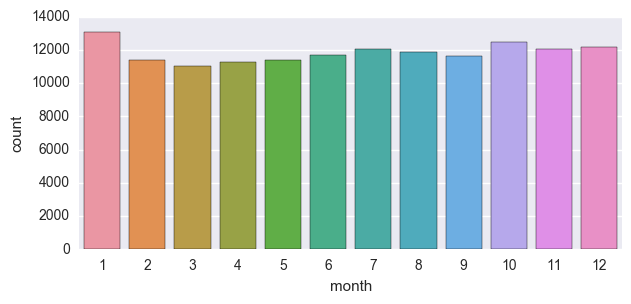

In [15]:
# let's check number of events per month
fig, ax = plt.subplots(figsize=(7,3))  
ax = sns.countplot(x="month", data=dt7,ax=ax)

October-January is definetely the worst period, probably due to the weather. Also, vacation period has higher number of events.

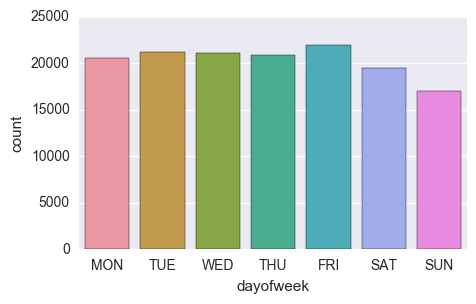

In [16]:
# let's check number of events per day of the week
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.countplot(x="dayofweek", data=dt7)
ax.axes.set_xticklabels(["MON", "TUE","WED","THU","FRI","SAT","SUN"])
pass

Friday is definetely the leader in this pack. Start of the weekend - that explains a lot :)

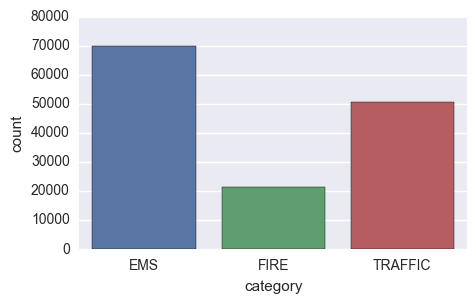

In [17]:
#let's see the size of each category (class)
# 0 = EMS (Emergency Medical Services), 1 = FIRE, 2 =  TRAFFIC
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.countplot(x="category", data=dt7)
ax.axes.set_xticklabels(["EMS","FIRE","TRAFFIC"])
pass

EMS conditions are the majority of all events, followed by traffic (mostly car accidents).

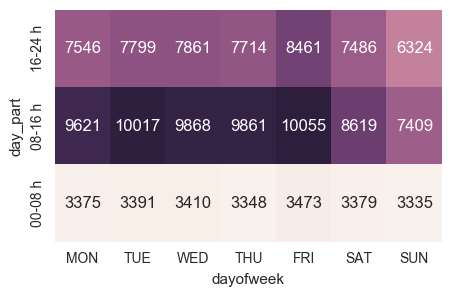

In [18]:
# lets check the time impact on the events
dt_timegrid = dt7.groupby(['dayofweek','day_part']).size().reset_index(name='count')
dt_timeheatmap = dt_timegrid.pivot(index='day_part', columns='dayofweek', values='count')
# generate heatmap
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.heatmap(dt_timeheatmap,annot=True, fmt="d",cbar=False)
ax.invert_yaxis()
ax.axes.set_yticklabels(["16-24 h","08-16 h","00-08 h"])
ax.axes.set_xticklabels(["MON", "TUE","WED","THU","FRI","SAT","SUN"])
pass

Luckily, events in the middle of the day dominates the whole 24h. That is also the time when most of the emergency teams operate with full performance.

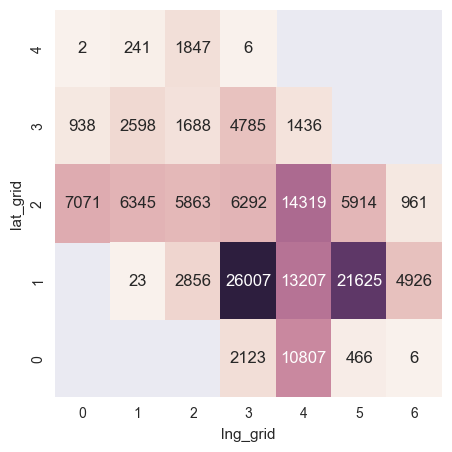

Longitude min-max: < -75.7297893 -74.9929755 > | range : 0.7368138
Latitude min-max: < 39.9525839 40.4799532 > | range : 0.5273693

US PA Montgomery County Reference map
Map source: OpenStreetMap.org, Map license: Open Data Commons Open Database License (ODbL).


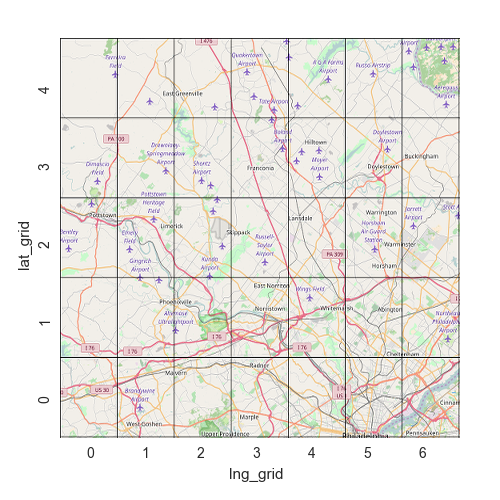

In [19]:
# now we can visualize our data on the geogrid.
dt_geogrid = dt7.groupby(['lat_grid','lng_grid']).size().reset_index(name='count')
dt_geoheatmap = dt_geogrid.pivot(index='lat_grid',columns='lng_grid', values='count')
# generate heatmap
fig, ax = plt.subplots(figsize=(5,5))  
ax = sns.heatmap(dt_geoheatmap,annot=True,fmt=".0f",cbar=False)
ax.invert_yaxis()
sns.plt.show()
print ("Longitude min-max: <",lng_min,lng_max,"> | range :",lng_range)
print ("Latitude min-max: <",lat_min,lat_max,"> | range :",lat_range)
#draw reference map
print ("\nUS PA Montgomery County Reference map") 
print ("Map source: OpenStreetMap.org, Map license: Open Data Commons Open Database License (ODbL).")
img = Image(filename = "montco-map-grid.png", width=480, height=480)
display(img)
# save plots locally

In [20]:
# reorganize table to have mor intuitive order of the features
final_columns = ["month","week","dayofweek","day","day_part","lat_grid","lng_grid","category"]
dt7 = dt6[final_columns]
dt7.head(3)

,month,week,dayofweek,day,day_part,lat_grid,lng_grid,category
7916,1,53,4,1,0,1,3,0
7917,1,53,4,1,0,1,3,0
7918,1,53,4,1,0,2,0,0


In [21]:
# let's describe the data again
dt7.describe()

,month,week,dayofweek,day,day_part,lat_grid,lng_grid,category
count,142352.000000,142352.000000,142352.000000,142352.000000,142352.000000,142352.000000,142352.000000,142352.000000
mean,6.534956,26.685407,2.908551,15.912105,1.207092,1.439341,3.412759,0.863212
std,3.485908,15.239628,1.953423,8.769763,0.705224,0.826899,1.455951,0.910901
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,13.000000,1.000000,8.000000,1.000000,1.000000,3.000000,0.000000
50%,7.000000,27.000000,3.000000,16.000000,1.000000,1.000000,4.000000,1.000000
75%,10.000000,40.000000,5.000000,23.000000,2.000000,2.000000,4.000000,2.000000
max,12.000000,53.000000,6.000000,31.000000,2.000000,4.000000,6.000000,2.000000


## 06. Model data for Machine Learning regression

In [22]:
# create separate datasets for categories and group them by all parameters to get count of events for a given group
groupby_list = ['month','week','dayofweek','day','day_part','lat_grid','lng_grid']
dt_cat = dict() # holder for subdatasets with categories. 
for item in CATEGORIES:
    dt_temp = dt7.loc[(dt7['category'] == CATEGORIES[item])]
    dt_cat[item] =  dt_temp.groupby(groupby_list).size().reset_index(name='count')
dt_cat['ALL'] = dt7.groupby(groupby_list).size().reset_index(name='count') # All data, without category grouping
dt_cat['ALL'].head(3) 

,month,week,dayofweek,day,day_part,lat_grid,lng_grid,count
0,1,1,0,4,0,0,3,1
1,1,1,0,4,0,0,4,2
2,1,1,0,4,0,0,5,1


In [23]:
dt_cat['ALL'].describe()

,month,week,dayofweek,day,day_part,lat_grid,lng_grid,count
count,19396.000000,19396.000000,19396.000000,19396.000000,19396.000000,19396.000000,19396.000000,19396.000000
mean,6.507166,26.634306,2.990462,15.783667,1.056197,1.801609,3.053671,7.339245
std,3.466914,15.164158,1.988070,8.815254,0.797869,1.049303,1.681422,7.945054
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,13.000000,1.000000,8.000000,0.000000,1.000000,2.000000,2.000000
50%,7.000000,27.000000,3.000000,16.000000,1.000000,2.000000,3.000000,4.000000
75%,10.000000,40.000000,5.000000,23.000000,2.000000,3.000000,4.000000,9.000000
max,12.000000,53.000000,6.000000,31.000000,2.000000,4.000000,6.000000,91.000000


In [24]:
# let's now create a function that will split data into train and test sets and run regresion algorithm on the data

def run_regression(name,input_dt):
    X = input_dt.iloc[:,[0,1,2,3,4,5,6]]
    Y = input_dt.iloc[:,[7]]
    Y = Y.values.reshape(len(X))
    validation_size = 0.20
    seed = 7
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = validation_size,random_state = seed)
    model = GradientBoostingRegressor(n_estimators=200, 
                                      learning_rate=0.1, max_depth=5, random_state=0, loss='ls', warm_start =  True)
    model.fit(X_train,Y_train)
    return name,model,r2_score(Y_test, model.predict(X_test))

# run model for all categories and put results into the table.
# also save trained models for later use
results_table = [["CATEGORY","R2 SCORE"]]
trained_models = dict() # holder for trained models
for item in dt_cat:
    results = run_regression(item,dt_cat[item])
    results_table.append([item,results[2]])
    trained_models[item] =  results[1]

print (to_text(results_table))

┌──────────┬────────────────┐
│ CATEGORY │ R2 SCORE       │
├──────────┼────────────────┤
│ Fire     │ 0.324846254407 │
├──────────┼────────────────┤
│ ALL      │ 0.811930416054 │
├──────────┼────────────────┤
│ Traffic  │ 0.594352576961 │
├──────────┼────────────────┤
│ EMS      │ 0.754139525183 │
└──────────┴────────────────┘


## 07. Predict events for a single day in 2017

In [25]:
# we will use trained GradientBoostingRegressor model to estimate 911 calls
# in a single day of 2017, based on the 2016 year data
# we need to generate list containing all time slots in a single day and "active" geogrid locations
# the selected date will be 19 May 2017 (arbitrary date)
# note we cannot use all geogrid locations as not for all we have the data
# and model will not be able to predict anything meaningful for them
# the county map does not cover the whole grid. 
# So we will use the previous dt_geogrid variable to get "active" locations
singleday_dt = []
# record structure is month,week,dayofweek,day,day_part,lat_grid,lng_grid
row_base = [5,20,4,19] #base row with date 19 May 2017, Wednesday. Change it to get another day.
for day_idx in range(24/hours_range):
    for idx,row in dt_geogrid.iterrows():
        singleday_dt.append(row_base+[day_idx,row['lat_grid'],row['lng_grid']]) 
singleday_dt = pd.DataFrame(singleday_dt,columns=final_columns[:7])
singleday_dt.head(3)

,month,week,dayofweek,day,day_part,lat_grid,lng_grid
0,5,20,4,19,0,0,3
1,5,20,4,19,0,0,4
2,5,20,4,19,0,0,5


In [26]:
# we will pass generated data to scikit-learn model predict method to see the result
predictions_all = trained_models['ALL'].predict(singleday_dt)
singleday_dt_full = singleday_dt
singleday_dt_full['events'] = predictions_all
print ("Total number of 911 events in selected day is : ", round(singleday_dt_full['events'].sum()))

Total number of 911 events in selected day is :  448.0


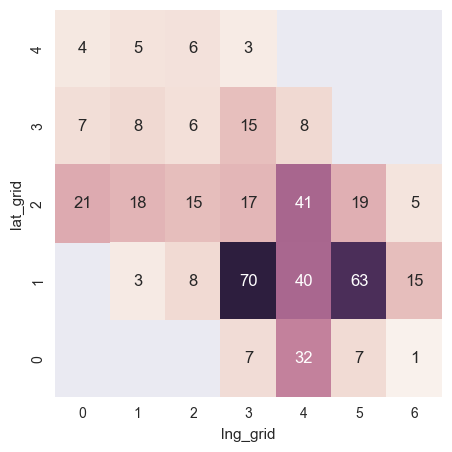

US PA Montgomery County Reference map
Map source: OpenStreetMap.org, Map license: Open Data Commons Open Database License (ODbL).


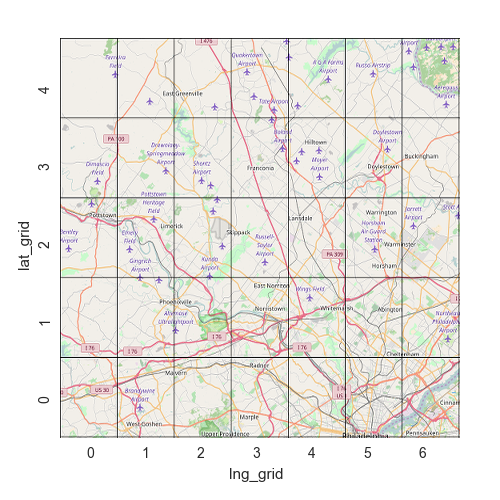

In [27]:
# now we can visualize our data for 19 May 2017 on the map.
dt_geogrid = singleday_dt_full.groupby(['lat_grid','lng_grid']).agg({'events': np.sum}).reset_index()
dt_geoheatmap = dt_geogrid.pivot(index='lat_grid', columns='lng_grid', values='events')
# generate heatmap
fig, ax = plt.subplots(figsize=(5,5))  
ax = sns.heatmap(dt_geoheatmap,annot=True,fmt=".0f",cbar=False)
ax.invert_yaxis()
sns.plt.show()
fig = ax.get_figure()
fig.savefig("6.png")
print ("US PA Montgomery County Reference map") 
print ("Map source: OpenStreetMap.org, Map license: Open Data Commons Open Database License (ODbL).")
img = Image(filename = "montco-map-grid.png", width=480, height=680)
display(img)

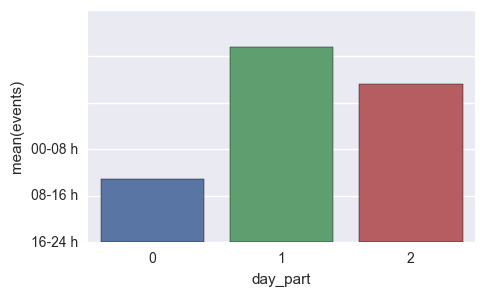

In [28]:
data_timeevents = singleday_dt_full.groupby(['day_part']).agg({'events': np.sum}).reset_index()
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x="day_part", y="events", data=data_timeevents)
ax.axes.set_yticklabels(["16-24 h","08-16 h","00-08 h"])
pass

## 08. Summary

Let's check whether we have achieved our goals:
1. predict number of help & rescue (911) events in US (PA) Montgomery County in arbitrary day of 2017
    * PASSED, we can predict data for any day using our trained model.
2. prediction should provide number of events by time of day and by general location
    * PASSED, we can get prediction per time of day and per geolocation grid
3. prediction should be based on 2016 data
    * PASSED, model is trained on 2016 data
4. we must know the accuracy of the prediction
    * PASSED, The overall accuracy (R2 score) for 2017 is 0.81
5. some guidance, regarding type of the event would be nice, too.
    * PARTIALLY PASSED. We know general relation between number of events in each category. So we know that most of events is in EMS category, followed by Traffic. Fire events are the last. However, the prediction accuracy for categories is too low to use it (is acceptable for for EMS where equals 0.75 , but for FIRE is just  0.32. Seems that fire events are quite hard to predict).